In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import statsmodels.api as sm
from pandas_datareader import data as pd_data
import laplacejumps as lj
import shelve
from scipy import special
from dask import bag as db
from dask.diagnostics import ProgressBar

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
mpl.pyplot.style.use('seaborn-talk')

In [3]:
lj.__version__

'0.03.08-py36_4'

## Load Data

In [4]:
with pd.HDFStore('../results/spy_5min_vol_estimates_2003-2017.hdf', mode='r') as volatility_store:
    real_vol = volatility_store['real_vol']
    bipower11_vol = volatility_store['bipower11_vol']
    bipower_jump_vol = volatility_store['bipower_jump_vol']

In [5]:
with pd.HDFStore('../results/spy_volatility_estimates_2003-2017.hdf', mode='r') as volatility_store:
    discrete_vol = volatility_store['discrete_vol_est']
    daily_rtn = volatility_store['daily_rtn'][discrete_vol.dropna().index]
    discrete_vol = volatility_store['discrete_trunc_vol']
    bipower_vol = volatility_store['bipower_vol']


In [6]:
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
discrete_vol['real_vol'] = real_vol

log_vol = (252 * discrete_vol).apply(np.log).dropna()
log_vol['excess_rtn'] = daily_rtn
weights = discrete_vol['quad']**(-1)
log_vol['weights'] = weights
log_vol.dropna(inplace=True)
log_vol['weights'] = log_vol.weights
log_vol['log_prop'] = special.logit(np.exp(log_vol.jumps - log_vol.quad))

In [7]:
with shelve.DbfilenameShelf('../results/rolling_model_estimates_logit.tmp', protocol=4) as database:
    models = [(key,val) for key,val in database.items()]    

## Setup

In [8]:
default_model = 'HAR-RV' 
filename = 'vol_forecast_tbl'
forecast_var = 'quad'
horizon_list = [1,5,20]
max_lag = 30

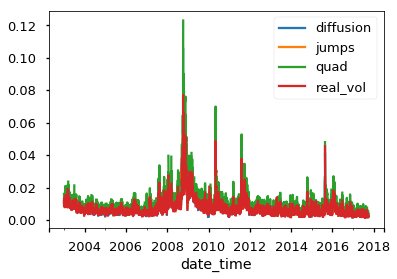

In [9]:
discrete_vol.applymap(np.sqrt).plot()

In [10]:
def model_eval_mse(arg):

    return (arg**2)

In [11]:
def model_eval_mae(arg):
    return (np.abs(arg))

In [12]:
eval_func = model_eval_mse

## Some Functions

In [13]:
def forecast_mse(date, model, horizon_list):

    h = np.amax(horizon_list)
    n = log_vol.index.get_loc(date)
    
    true = log_vol.loc[:,forecast_var].iloc[n+1:n+h+1]
    pred = model.predict(h=h).loc[:,forecast_var].values

    model_errors = pd.DataFrame(eval_func(abs(true.values-pred)), index=true.index).iloc[np.ravel(horizon_list)-1].T
    model_errors.columns = horizon_list
    
    return model_errors

In [14]:
valid_models = [model for model in models if lj.compute_names_in(forecast_var) in model[0].split("/")[2]]
bag2 = db.from_sequence(models)
with ProgressBar():
    results = lj.reorganize_results(bag2.map(lj.extract_results, loss_func=forecast_mse,
                                      horizon_list=horizon_list).compute())

[########################################] | 100% Completed | 12.6s


In [15]:
expanding_errors = log_vol[forecast_var].expanding().apply(lambda x: x[-1] - x.mean()).to_frame()

In [18]:
summary_results = lj.tree()
for vol_name, vol_data in results.items():
    for regresssand_name, regressand_data in vol_data.items():
        for regressor_name, regressor_data in regressand_data.items():
            for horizon, model_errors in regressor_data.items():
                dates = model_errors.index
                data_in = log_vol['excess_rtn'][pd.to_datetime(dates)].to_frame() 

                default_errors = eval_func(expanding_errors.loc[dates])
                model_errors = model_errors.iloc[-default_errors.shape[0]:]
          
                default_mean_loss = np.asscalar(np.mean(default_errors))
                model_mean_loss =  np.asscalar(np.mean(model_errors))
                loss_ratio = model_mean_loss / default_mean_loss
                
                num_har_lags = 1 + np.amax(horizon_list) + max_lag
                weighted_errors =  np.ravel(default_errors) - np.ravel(model_errors)
                dm_tvalue = np.asscalar(sm.OLS(endog=weighted_errors,exog=np.ones(weighted_errors.shape[0])).fit(
                    cov_type='HAC', cov_kwds={'maxlags':num_har_lags}).tvalues)
                
                return_dict =  {'r_squared': 1 - loss_ratio**2,'DM_tvalue':dm_tvalue}
                
                summary_results[vol_name][regresssand_name][horizon][regressor_name] =  return_dict

In [19]:
import jinja2
import os
from jinja2 import Template
latex_jinja_env = jinja2.Environment(
    block_start_string = '\BLOCK{',
    variable_start_string = '\VAR{',
    variable_end_string = '}',
    block_end_string = '}',
    comment_start_string = '\#{',
    comment_end_string = '}',
    line_statement_prefix = '%%',
    line_comment_prefix = '%#',
    trim_blocks = True,
    autoescape = False,
    loader = jinja2.FileSystemLoader(os.path.abspath('../doc/tables'))
)
template = latex_jinja_env.get_template(f'{filename}.tex.tmpl')

with open(f'../doc/tables/{filename}.tmp.tex', mode='w') as file:
    file.write(template.render(results=summary_results, forecast_var=lj.compute_names_in(forecast_var)))
    print(template.render(results=summary_results, forecast_var=lj.compute_names_in(forecast_var)))

    







    
    

    \begin{table}[htb]
        \centering
        \caption{Log Volatility Forecasting Results}
        \label{tbl:log_volatility_forecasting_comparison}
            
        \sisetup{
            table-align-text-pre=false,
            table-align-text-post=false,
            round-mode=places,
            table-space-text-pre=\lbrack,
            table-space-text-post=\rbrack,
        }
                
            \begin{tabularx}{9in}{l | *{8}{S[table-format=2.2]}}
                \multicolumn{8}{X}{\textbf{Regressand:} \totalvolt} \\ 
                \toprule
                    & \multicolumn{8}{X}{\textbf{Models:}} \\
        h &     {AR(1)-\rxt}  & {AR(1)-\totalvolt--$\log(\jumppropt)$}  & {AR(1)-\totalvolt}  \\  
    \midrule
    1 &     \num{0.0326}  & \num{0.982}  & \num{0.9824}  \\ 
         &     [\num{1.4304}] & [\num{9.9511}] & [\num{9.9363}] \\5 &     \num{0.0129}  & \num{0.9026}  & \num{0.9052}  \\ 
         &     [\num{0.2145}] & [\num{8.0722}] & [\num